In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob 
import pandas as pd
import medpy.io
from utils import plot_comparison 
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Training and Validation Data

In [7]:
#path 
storage_path = "/home/kevinteng/Desktop/ssd02/"
#original 
training_ds_path = storage_path+"MICCAI_BraTS2020_TrainingData/"
validation_ds_path = storage_path+"MICCAI_BraTS2020_ValidationData/"
#preprocessed
training_pre = storage_path+"BraTS2020_preprocessed02/Training_pre/"
validation_pre = storage_path+"BraTS2020_preprocessed02/Validation_pre/"

In [27]:
def create_data(input_path, output_path, min_max_norm = False, validation = False, 
                modal_swapaxes = False, label_swapaxes =True, verbose=True):
    if validation==False:
        csv_path = glob.glob(input_path+"name_mapping*.csv")
        csv_file = pd.read_csv(csv_path[0])
        grade = np.array(csv_file["Grade"].tolist()) #csv list with HGG or LGG
        #index grade type from csv
        grade_type = np.unique(grade) #class: HGG or LGG
        #create folder for HGG and LGG
        for types in grade_type:
            HGG_LGG_dir = output_path+"/"+types
            if not os.path.exists(HGG_LGG_dir):
                os.makedirs(HGG_LGG_dir)
    #create directory to store validation data 
    else: #validation == True
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    HGG_count = 0
    LGG_count = 0
    val_count = 0
    for indx, patient in enumerate(sorted(os.listdir(input_path))):
        #patient => (patient id) BraTS20_Training_001
        #ex:/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
        input_path01 = os.path.join(input_path+patient+"/")
        #for training data
        if not patient.endswith('.csv') and validation==False: #do not need to read .csv files
            #direct path to either HGG or LGG w.r.t patients
            if grade[indx]=='HGG':
                output_path01 = os.path.join(output_path+"/HGG/")
                HGG_count+=1 #increment for HGG 
            else:
                output_path01 = os.path.join(output_path+"/LGG/")
                LGG_count+=1 #increment for LGG
            #path to store labels for training data
            save_lbl = output_path01+"seg/"
            if not os.path.exists(save_lbl):
                os.makedirs(save_lbl)
            lbl_path = os.path.join(save_lbl)
        #for validation data
        elif not patient.endswith('.csv') and validation!=False:
            output_path01 = output_path
            val_count+=1
        else: #skip csv file
            continue
        #path to store stack image for last channel
        save_stack = output_path01+"stack/"
        if not os.path.exists(save_stack):
            os.makedirs(save_stack)
        stack_path = os.path.join(save_stack)
        #create empty numpy array to stack the modals in the last channel
        multimodal_stack = np.zeros((155,240,240,4), dtype=np.float32)
        for multi_modals in sorted(os.listdir(input_path01)): #flair,t1,t1ce,t2
            #'BraTS20_Training_001_flair.nii.gz' => flair
            modal = multi_modals.split('.')[0].split('_')[-1]
            #read imgs
            input_path02 = os.path.join(input_path01+multi_modals)
            read_med_img,_ = medpy.io.load(input_path02)
            img_slices = read_med_img.shape[-1] #last channel is image slices
            #min max normalization switch, label 'seg' not included
            if modal!= 'seg' and min_max_norm==True:
                norm_list = []
                for i in range(img_slices):
                    max_val = np.max(read_med_img[:,:,i]) #max value in that slice
                    min_val = np.min(read_med_img[:,:,i]) #min value of that slice
                    norm = (read_med_img[:,:,i] - min_val)/(max_val-min_val)
                    norm_list.append(norm)
                read_med_img = np.array(norm_list, dtype=np.float32) #=>(155, 240, 240)
                read_med_img = np.nan_to_num(read_med_img)#hacky trick to purge errors
                if modal_swapaxes==True: #=>(240, 240, 155) in case of 3D 
                    read_med_img = np.swapaxes(read_med_img, 0,1)
                    read_med_img = np.swapaxes(read_med_img, 1,2)
                if modal=='flair':
                    multimodal_stack[:,:,:,0] = read_med_img
                if modal=='t1':
                    multimodal_stack[:,:,:,1] = read_med_img
                if modal=='t1ce':
                    multimodal_stack[:,:,:,2] = read_med_img
                if modal=='t2':
                    multimodal_stack[:,:,:,3] = read_med_img
                save_multimodal_stack = np.save(stack_path+"/{}_stack.npy".format(patient), multimodal_stack)
            if modal== 'seg':
                if label_swapaxes==True: 
                    #(240, 240, 155)=>(155, 240, 240) 
                    # to make the dimension compatible with modalitiy files
                    read_med_img = np.swapaxes(read_med_img, 0,1)
                    read_med_img = np.swapaxes(read_med_img, 0,2)
                save_lbl = np.save(lbl_path+"/{}_lbl.npy".format(patient), read_med_img)
    #output info after preprocessing
    if verbose:
        print("Medical image dimensions:{}".format(multimodal_stack.shape))
        if not validation:
            print("HGG patients: {}".format(HGG_count))
            print("LGG patients: {}".format(LGG_count))
            print("Total patients: {}".format(HGG_count + LGG_count))
            print("Total image slices: {}".format((HGG_count + LGG_count)*img_slices))
        else:
            print("Total patients: {}".format(val_count))
            print("Total image slices: {}".format(val_count*img_slices))

In [34]:
# #preprocessed training data
# create_data(training_ds_path, training_pre, min_max_norm = True)

In [32]:
#preprocessed validation data
# create_data(validation_ds_path, validation_pre, min_max_norm = True, validation = True)

In [2]:
tst_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed02/Validation_pre/stack/BraTS20_Validation_001_stack.npy'
tst_npy = np.load(tst_path)
print(tst_npy.shape)

(155, 240, 240, 4)


In [3]:
multimodal_slices = tst_npy[:,:,:,0:3]
print(multimodal_slices.shape)

(155, 240, 240, 3)


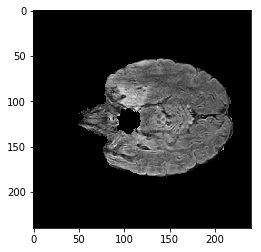

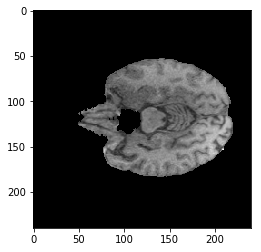

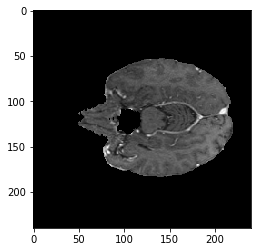

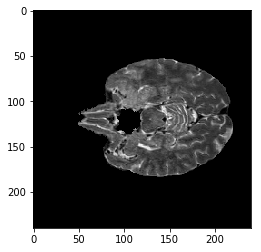

In [31]:
for i in range(4):
    plt.imshow(tst_npy[50,:,:,i], cmap='gray')
    plt.show()

---

# Stack Images 

In [ ]:
def threeD_to_twoD(save_dir, input_path):
    '''
    Stack all the images according to slices of a patient to create a 2D image stacks
    
    @param save_dir: The directory where the images need to be save
    @param input_path: The path where pre-processed .npy file is stored 
    '''
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for brain_tumour in sorted(os.listdir(input_path)): #HGG/LGG
        #create folder for HGG or LGG
        #only for Training folder since HGG/LGG are not available
        #for validation dataset
        save_path01 = save_dir + brain_tumour
        if not os.path.exists(save_path01):
            os.makedirs(save_path01)
        merge_path_00 = os.path.join(input_path+brain_tumour+"/")
        for multi_modal in sorted(os.listdir(merge_path_00)): #flair,t1,t1ce,t2,seg
            #create folder for multi modals
#             save_path02 = save_path01 + "/"+multi_modal
#             if not os.path.exists(save_path02):
#                 os.makedirs(save_path02)
            merge_path_01 = os.path.join(merge_path_00+multi_modal+'/')
            img_stack = []
            for patient in sorted(os.listdir(merge_path_01)): #patient.npy
                merge_path_02 = os.path.join(merge_path_01+patient)
                med_img = np.load(merge_path_02).astype(np.float32) #channel front
                for i in range(med_img.shape[-1]): #last dimension is the number of slices
                    img_stack.append(med_img[:,:,i])
            img_stack = np.array(img_stack)
            np.save(save_path01+'/{}_stack.npy'.format(multi_modal), img_stack)

In [ ]:
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack02/"
input_path = "/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed02/Training_pre/"

threeD_to_twoD(save_dir, input_path)